<a href="https://colab.research.google.com/github/shriyakashyap/kidf-face-recognition/blob/main/kidf_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vkehfdl1/kidf-kpop-idol-dataset-female

kidf-kpop-idol-dataset-female.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/kidf-kpop-idol-dataset-female.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

In [ ]:
TRAIN_PATH = '/content/HQ_512x512/HQ_512x512/'
TEST_PATH = '/content/test_final_with_degrad/test/'

In [ ]:
train = pd.read_csv('kid_f_train.csv')
test = pd.read_csv('kid_f_test.csv')

preparing data!

In [ ]:
class_names = train['name'].unique().tolist()
tclass_names = test['name'].unique().tolist()
available_class = list(set(class_names)&set(tclass_names))
print(len(available_class))
available_class

23


['kanghyewon',
 'bravegirls_yujeong',
 'hondahitomi',
 'joyuri',
 'bravegirls_yuna',
 'jennie',
 'hongeunchae',
 'sakura',
 'lisa',
 'rose',
 'wonyoung',
 'jisoo',
 'yujin',
 'winter',
 'karina',
 'kimminju',
 'nayeon',
 'choiyena',
 'kimchaewon',
 'bravegirls_eunji',
 'giselle',
 'kazuha',
 'oliviahye']

In [ ]:
traini = []
testi = []
for item in available_class:
    traini += train[train['name']==item].index.tolist()
    testi += test[test['name']==item].index.tolist()

train_df = train.iloc[traini]
test_df = test.iloc[testi]
display(train_df)

,file_name,name
753,2383.jpg,kanghyewon
754,2384.jpg,kanghyewon
755,2386.jpg,kanghyewon
756,2387.jpg,kanghyewon
757,2390.jpg,kanghyewon
...,...,...
1366,5320.jpg,oliviahye
1367,5327.jpg,oliviahye
1368,5376.jpg,oliviahye
1369,5377.jpg,oliviahye


In [ ]:
grp_count = train_df.groupby('name').aggregate('count').rename(columns = {'file_name' : 'count_num'}).reset_index().sort_values(by="count_num",ascending=False)
grp_count

,name,count_num
15,lisa,1282
18,rose,1245
8,jisoo,1023
7,jennie,414
14,kimminju,261
9,joyuri,257
3,choiyena,135
5,hondahitomi,119
13,kimchaewon,119
10,kanghyewon,83


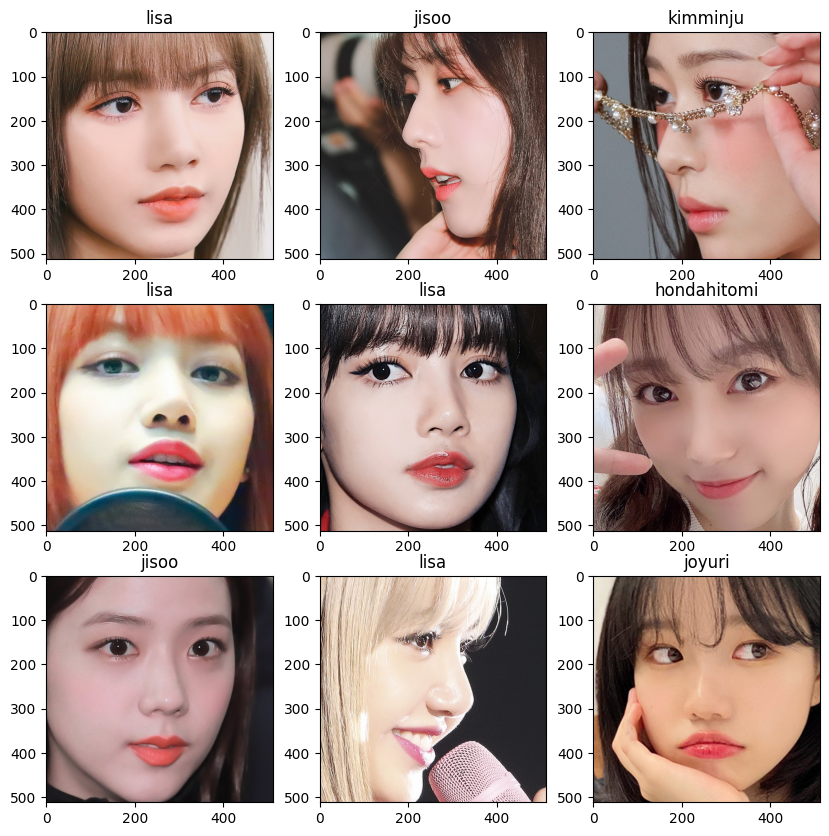

In [ ]:
#plotting images w idol names
plt.figure(figsize=(10,10))

for i in range(9):
    row = train_df.sample(1)
    path = TRAIN_PATH + row.file_name.values[0]
    img = Image.open(path)
    ax = plt.subplot(3,3,i+1)
    ax.set_title(row.name.values[0])
    plt.imshow(img)

In [ ]:
X_train,X_val,_,_ = train_test_split(train_df,
                                      train_df.name,
                                      stratify=train_df.name,
                                      test_size= 0.2)

In [ ]:
X_train['type'] = 'train'
X_val['type'] = 'val'

In [ ]:
full_df = pd.concat([X_train,X_val])

In [ ]:
!mkdir data/
!mkdir data/train
!mkdir data/val

mkdir: cannot create directory ‘data/’: File exists
mkdir: cannot create directory ‘data/train’: File exists
mkdir: cannot create directory ‘data/val’: File exists


In [ ]:
for cat in full_df.name.unique():
    os.system(f"mkdir data/train/'{cat}'")
    os.system(f"mkdir data/val/'{cat}'")

In [ ]:
display(full_df)

,file_name,name,type
1158,4229.jpg,kimchaewon,train
3220,55599.jpg,rose,train
1072,3839.jpg,sakura,train
2357,33389.jpg,jisoo,train
2644,38356.jpg,jisoo,train
...,...,...,...
1623,9639.jpg,jisoo,val
4819,78149.jpg,lisa,val
1668,9875.jpg,jisoo,val
1646,9720.jpg,jisoo,val


this bit took me so long to figure out, only to realise that the folder path was wrong... silly me

In [ ]:
for i,rows in full_df.iterrows():
    cat = rows['name']
    ipath = TRAIN_PATH + rows['file_name']
    section = rows['type']
    opath = ipath.replace(f"/content/HQ_512x512/HQ_512x512/",f"./data/{section}/{cat}/")
    os.system(f"cp '{ipath}' '{opath}'")

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

In [ ]:
train_folder = "/content/data/train"
val_folder = "/content/data/val"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                               horizontal_flip=True,
                               rotation_range = 4,
                               zoom_range=0.1,
                               height_shift_range = 0.2,
                               width_shift_range = 0.2,)
                               #preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(train_folder,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(299,299))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

validation_generator = validation_datagen.flow_from_directory(val_folder,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(299, 299))

Found 5411 images belonging to 23 classes.
Found 3186 images belonging to 23 classes.


dataset is ready to use! :D

In [ ]:
model1 = Sequential()

model1.add(Conv2D(32, (3,3), input_shape = (299, 299, 3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(2))

model1.add(Conv2D(64, (3,3), input_shape = (299, 299, 3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

model1.add(Flatten())
model1.add(Dense(units = 512, activation = 'relu'))
model1.add(Dropout(0.1))

#output

model1.add(Dense(units = 23, activation = 'softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 299, 299, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 149, 149, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
#compiling model

optm = Adam(learning_rate = 0.001)

model1.compile(optimizer = optm,
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_loss', patience = 4)
checkpoint = ModelCheckpoint('kidf-facial-recognition', monitor = 'val_acc')

In [ ]:
history = model1.fit(train_generator, batch_size = 32, epochs = 20, validation_data = validation_generator, callbacks = [early_stop, checkpoint])

Epoch 1/20
85/85 [==============================] - 207s 2s/step - loss: 7.6631 - accuracy: 0.3229 - val_loss: 94.5439 - val_accuracy: 0.0100
Epoch 2/20
85/85 [==============================] - 210s 2s/step - loss: 2.0448 - accuracy: 0.4045 - val_loss: 37.3975 - val_accuracy: 0.1651
Epoch 3/20
85/85 [==============================] - 195s 2s/step - loss: 1.9007 - accuracy: 0.4190 - val_loss: 9.7760 - val_accuracy: 0.3613
Epoch 4/20
85/85 [==============================] - 197s 2s/step - loss: 1.7926 - accuracy: 0.4626 - val_loss: 13.7041 - val_accuracy: 0.3305
Epoch 5/20
85/85 [==============================] - 259s 3s/step - loss: 1.7754 - accuracy: 0.4591 - val_loss: 5.4595 - val_accuracy: 0.3553
Epoch 6/20
85/85 [==============================] - 213s 3s/step - loss: 1.6658 - accuracy: 0.4909 - val_loss: 2.6865 - val_accuracy: 0.4325
Epoch 7/20
85/85 [==============================] - 186s 2s/step - loss: 1.6167 - accuracy: 0.5125 - val_loss: 1.4021 - val_accuracy: 0.5606
Epoch 8/20

Train accuracy is low as the dataset itself is flawed. There is a huge imbalance in the distribution of images (some classes have over 1000 images and others have only 6). There is a little overfitting; I tried to reduce this by reducing the learning rate, adding batch normalization, data augmentation etc. So, an accuracy between 50-60% is expected (and probably the best I can get).

In [ ]:
preds1 = model1.predict(validation_generator, batch_size = 16)

print("Total predicted classes are: ", len(preds1))

50/50 [==============================] - 21s 419ms/step
Total predicted classes are:  3186


In [ ]:
import cv2

def make_prediction(IMG_PATH):
    img = cv2.resize(cv2.imread(IMG_PATH),(299,299))
    img_normalised = img/255
    pred = model1.predict(np.array([img_normalised]))
    name_of_img = np.argmax(pred)
    return dic_id_name[name_of_img]

In [ ]:
class_name = train_generator.class_indices
dic_id_name = {y: x for x, y in class_name.items()}
dic_id_name

{0: 'bravegirls_eunji',
 1: 'bravegirls_yujeong',
 2: 'bravegirls_yuna',
 3: 'choiyena',
 4: 'giselle',
 5: 'hondahitomi',
 6: 'hongeunchae',
 7: 'jennie',
 8: 'jisoo',
 9: 'joyuri',
 10: 'kanghyewon',
 11: 'karina',
 12: 'kazuha',
 13: 'kimchaewon',
 14: 'kimminju',
 15: 'lisa',
 16: 'nayeon',
 17: 'oliviahye',
 18: 'rose',
 19: 'sakura',
 20: 'winter',
 21: 'wonyoung',
 22: 'yujin'}

In [ ]:
for i,rows in test.iterrows():
    path = TEST_PATH + rows['file_name']
    if not os.path.exists(path):
        print(i)
        print(path)

83
/content/test_final_with_degrad/test/1792 .jpg


In [ ]:
test['file_name'][83] = '1792.jpg'

1/1 [==============================] - 0s 98ms/step


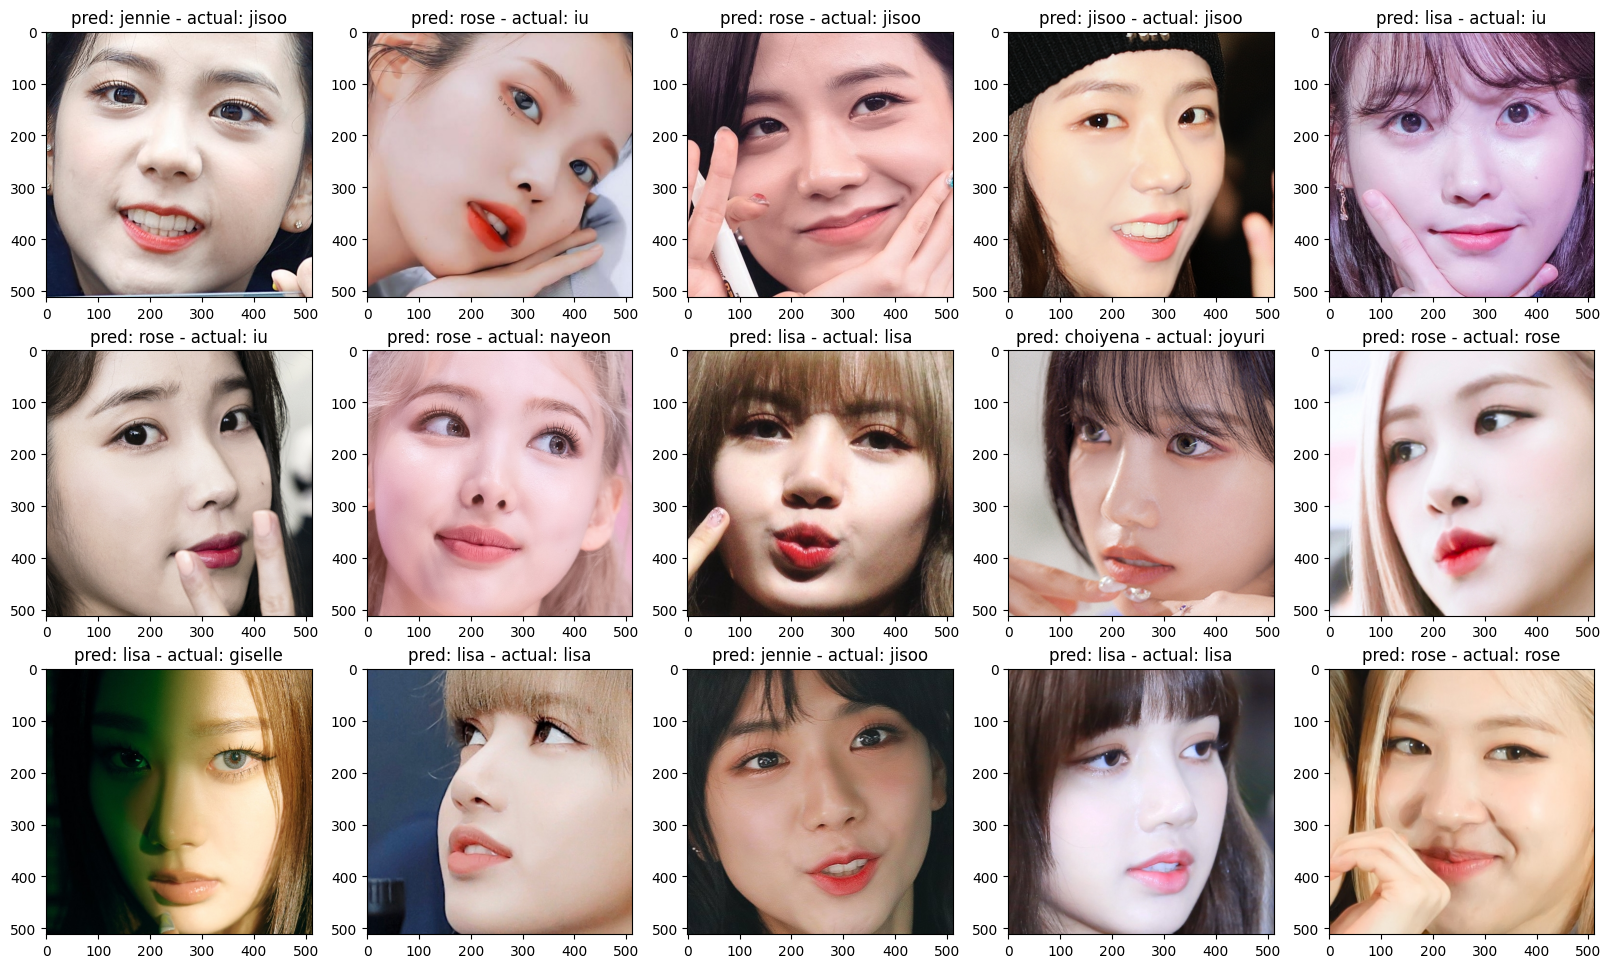

In [ ]:
plt.figure(figsize=(20,20))

for i in range(15):
    row = test.sample(1)
    path = TEST_PATH + row.file_name.values[0]
    preds = make_prediction(path)
    img = Image.open(path)
    ax = plt.subplot(5,5,i+1)
    ax.set_title('pred: ' + preds + ' - actual: ' + row.name.values[0])
    plt.imshow(img)

As expected, very 50/50 results! This could be improved with a more uniform dataset - even after applying all the methods to improve accuracy, the accuracy is still quite low. But, this was fun (and tedious) to make! :)

main references:

https://www.kaggle.com/code/huhuyngun/kpop-idol-using-xception (for preparing and testing data)

https://medium.com/mlearning-ai/build-your-own-facial-recognition-system-to-work-even-with-a-face-mask-b240539222f6 (for building the CNN)